# 과제용

## Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224,224] 
              
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

### 2.1) 데이터 가져오기

In [3]:
def is_image_size_greater_or_equal_to_224(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image)
    height, width, _ = tf.unstack(tf.shape(image))
    return height >= 224 and width >= 224

def filter_images_by_size(file_list):
    return [file for file in file_list if is_image_size_greater_or_equal_to_224(file)]

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 이미지 사이즈가 224 보다 작은 이미지 제외
train_filenames = filter_images_by_size(train_filenames)
val_filenames = filter_images_by_size(val_filenames)

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train :',len(train_filenames))
print('test :',len(test_filenames))
print('val :',len(val_filenames))

train : 4185
test : 624
val : 1047


### 2.x) train 일반vs폐렴 비율 확인

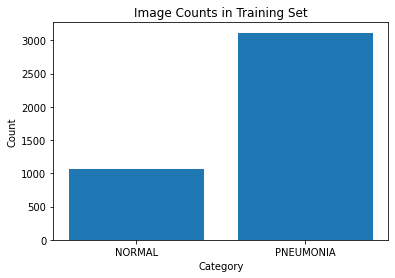

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# 막대 그래프 시각화
categories = ['NORMAL', 'PNEUMONIA']
counts = [COUNT_NORMAL, COUNT_PNEUMONIA]

plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Image Counts in Training Set')
plt.show()

### 2.x) 데이터셋 변환(라벨 미포함)

In [6]:
# 리스트를 텐서플로우의 데이터셋(tf.data.Dataset)으로 변환해주는 역할
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print('train :', len(train_list_ds))
print('val :', len(val_list_ds))

train : 4185
val : 1047


## 2.x) train vs val 비율 확인

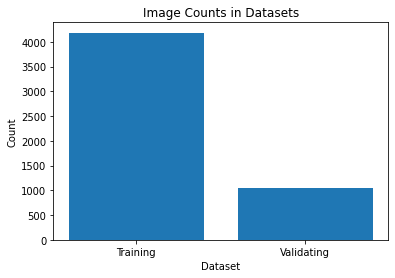

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 막대 그래프 시각화
categories = ['Training', 'Validating']
counts = [TRAIN_IMG_COUNT, VAL_IMG_COUNT]

plt.bar(categories, counts)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.title('Image Counts in Datasets')
plt.show()


### 2.x) 데이터셋 변환2(라벨 포함)

In [8]:
def show_images_with_condition(file_list, condition, num_images=5):
    count = 0
    for filename in file_list:
        img = tf.io.read_file(filename)
        
        # 이미지를 JPEG 형식으로 디코딩하도록 변경
        img = tf.image.decode_jpeg(img, channels=3)

        # 이 부분을 추가하여 흑백으로 변환 후 다시 3채널로 되돌림
        img_gray = tf.image.rgb_to_grayscale(img)
        img_gray_rgb = tf.image.grayscale_to_rgb(img_gray)

        if condition(img.shape):
            print("Image shape:", img_gray_rgb.shape)
            plt.imshow(img_gray_rgb)
            plt.axis('off')
            plt.show()
            count += 1
        if count == num_images:
            break

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    # 흑백으로 변환
    img_gray = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img_gray)
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    # 라벨 검출
    parts = tf.strings.split(file_path, os.path.sep)
    result = (parts[-2] == "PNEUMONIA") # True or False , 일반 or 폐렴
    label = result
    
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# num_parallel_calls 매개변수는 병렬 처리를 위해 사용되며, 
# AUTOTUNE 상수는 TensorFlow에서 자동으로 최적화된 값을 사용하도록 합니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

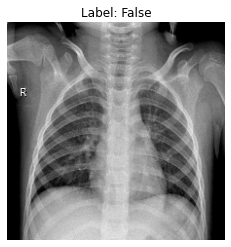

In [11]:
first_data = train_ds.take(1)

for image, label in first_data:
    # 이미지 시각화
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')  # 축 눈금 숨김
    plt.show()

### 2.x) test 데이터변환2

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2.x) prepare_for_training + Aug 추가

- `augmentation`

- `prepare_for_training` 

함수는 학습 데이터셋(ds)을 `효율적으로 학습`에 사용할 수 있도록 데이터를 처리하는 함수입니다. 학습 데이터셋을 처리하는 과정에서 다음과 같은 단계들을 거칩니다:

1. 셔플(Shuffle): 데이터셋을 랜덤하게 섞어서 학습 과정에서 데이터의 순서를 무작위로 만듭니다. 이렇게 하면 모델이 데이터의 순서에 의존하는 것을 방지하고 일반화 성능을 향상시킬 수 있습니다.

2. 반복(Repeat): 데이터셋을 여러 번 반복해서 사용할 수 있도록 합니다. 학습 과정에서 여러 epoch를 수행하기 위해 데이터를 반복하는 것이 일반적입니다.

3. 배치 처리(Batch): 데이터를 작은 묶음(batch)으로 나누어 모델이 일괄적으로 처리할 수 있도록 합니다. 미니 배치(mini-batch) 학습은 모델이 전체 데이터를 한 번에 처리하는 것보다 효율적입니다.

4. 사전 로딩(Prefetch): 학습 데이터를 모델에 공급하기 전에 사전에 로딩하여 데이터를 미리 준비해두는 것입니다. 이렇게 함으로써 모델이 학습과정에서 데이터 로딩으로 인한 대기 시간을 최소화할 수 있습니다.

In [13]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 `show_batch()` 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

### 3.x) Aug 적용 확인(좌우반전)

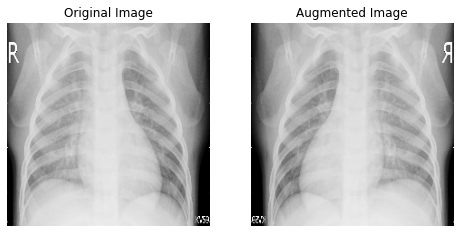

In [23]:
# train_ds 데이터셋에서 하나의 이미지를 가져옵니다.
for image, label in train_ds.take(1):
    original_image = image[0]  # 첫 번째 이미지
    augmented_image, label = augment(image[0], label)
    break

# 시각화를 위해 이미지를 변환합니다.
original_image = original_image.numpy()
augmented_image = augmented_image.numpy()

# 이미지를 시각화합니다.
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

plt.show()


### 3.x) 예시 이미지

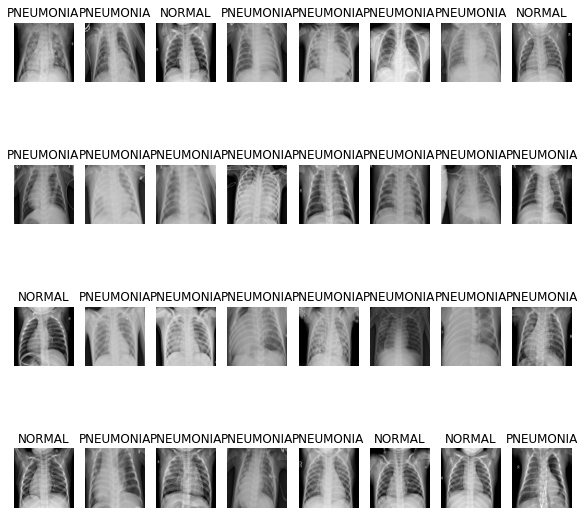

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. 모델링 


### ResNet-18

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras import Model, Input

def res_block(inputs, filters, downsample=False):
    stride = 1
    if downsample:
        stride = 2
        identity = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        identity = BatchNormalization()(identity)
    else:
        identity = inputs

    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Add()([x, identity])
    outputs = Activation('relu')(outputs)
    return outputs

def build_resnet18(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = res_block(x, 64)
    x = res_block(x, 64)
    
    x = res_block(x, 128, downsample=True)
    x = res_block(x, 128)

    x = res_block(x, 256, downsample=True)
    x = res_block(x, 256)
    
    x = res_block(x, 512, downsample=True)
    x = res_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    resnet18 = Model(inputs, outputs)

    return resnet18

### CNN

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

- `class_weight`
    - 만약 이러한 처리를 생략한다면 어떻게 될까요? 
    - 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?


In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [19]:
from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    # ResNset18
    #model = build_resnet18()
    
    # CNN
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    optimizer = Adam(learning_rate=0.01)
    
    model.compile(
        optimizer = 'adam', # 'adam' , 0.001
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #model.summary()

In [20]:
from keras.callbacks import EarlyStopping

with tf.device('/GPU:0'):
    es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es],
    )

Epoch 1/10
130/130 [==============================] - 191s 930ms/step - loss: 0.3445 - accuracy: 0.8279 - precision: 0.9641 - recall: 0.7985 - val_loss: 0.5941 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 125s 967ms/step - loss: 0.2232 - accuracy: 0.9175 - precision: 0.9742 - recall: 0.9134 - val_loss: 0.7900 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 126s 977ms/step - loss: 0.1525 - accuracy: 0.9435 - precision: 0.9838 - recall: 0.9396 - val_loss: 1.3473 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 129s 998ms/step - loss: 0.1699 - accuracy: 0.9363 - precision: 0.9784 - recall: 0.9351 - val_loss: 2.1382 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 134s 1s/step - loss: 0.1449 - accu

## Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

### 7.x) Train & Valid

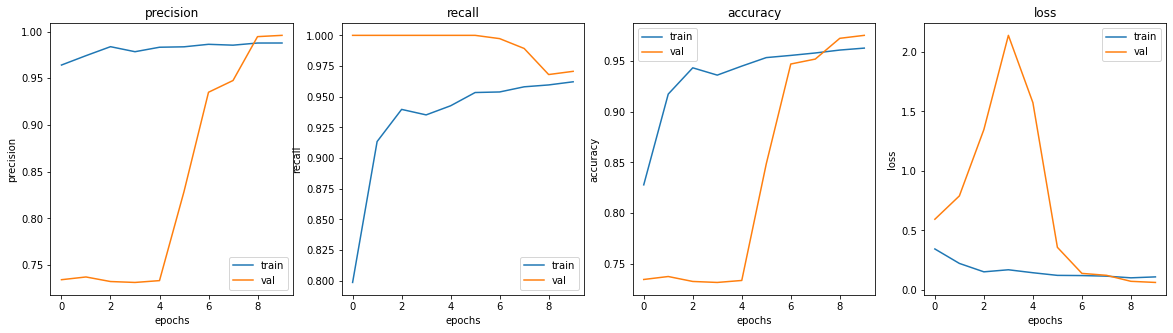

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(met)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7.x) Test

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 13s 636ms/step - loss: 0.8289 - accuracy: 0.7708 - precision: 0.7335 - recall: 0.9949
Loss: 0.828903079032898,
Accuracy: 0.7708333134651184,
Precision: 0.7334593534469604,
Recall: 0.9948717951774597


# 기록

## 실험 1) Batch Size 차이 알아보기

- 결론 : test Acc가 모두 0.625가 나온다. 모델 교체가 필요함(더 가벼운 모델로)

- ResNet 18
    - Set
        - Epoch : 10
        - `Batch : 16`
        - Aug : True
    - test
        - Loss: 2.556105375289917,
        - Accuracy: 0.625,
        - Precision: 0.625,
        - Recall: 1.0
        
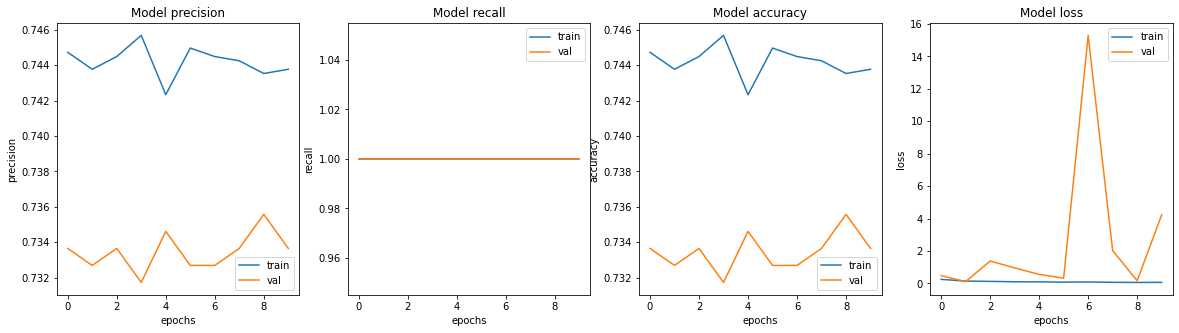


- ResNet 18
    - Set
        - Epoch : 10
        - `Batch : 128`
        - Aug : True
    - test
        Loss: 12.248528480529785,
        - Accuracy: 0.625,
        - Precision: 0.625,
        - Recall: 1.0
        
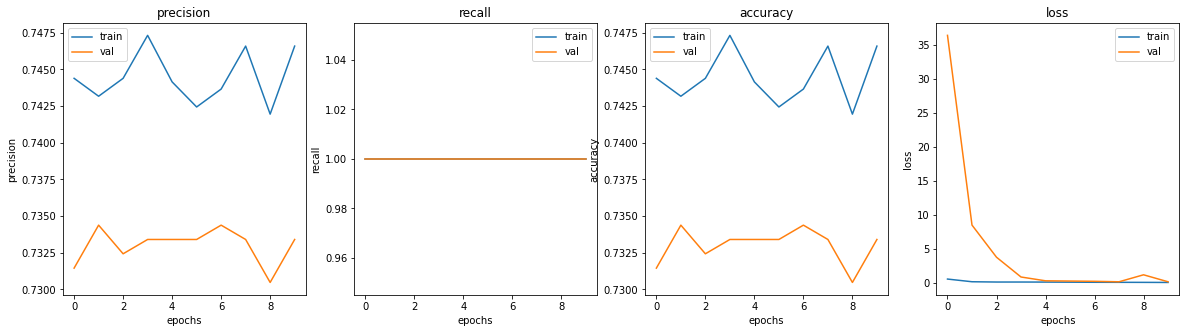

- ResNet 18
    - Set
        - Epoch : 10
        - `Batch :256`
        - Aug : True
    - test
        - Loss: 4.934681415557861,
        - Accuracy: 0.625,
        - Precision: 0.625,
        - Recall: 1.0
        
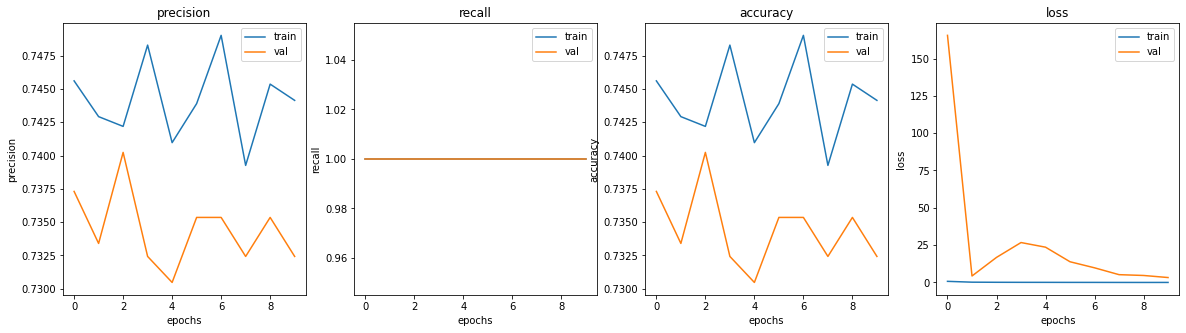

## 실험 2) 데이터 전처리 추가 실험

- CNN
    - Set
        - Epoch : 10
        - Batch :16
        - Aug : `False`
    - test
        - Loss: 0.5970589518547058,
        - `Accuracy: 0.6682`692170143127,
        - Precision: 0.6532663106918335,
        - Recall: 1.0
        


- CNN
    - Set
        - Epoch : 10
        - Batch :16
        - Aug : True
        - 추가 사항 : 
            - `이미지 흑백 변환`
            - `224 보다 작은 이미지 제거`
    - test
        - Loss: 0.828903079032898,
        - `Accuracy: 0.7708`333134651184,
        - Precision: 0.7334593534469604,
        - Recall: 0.9948717951774597
        
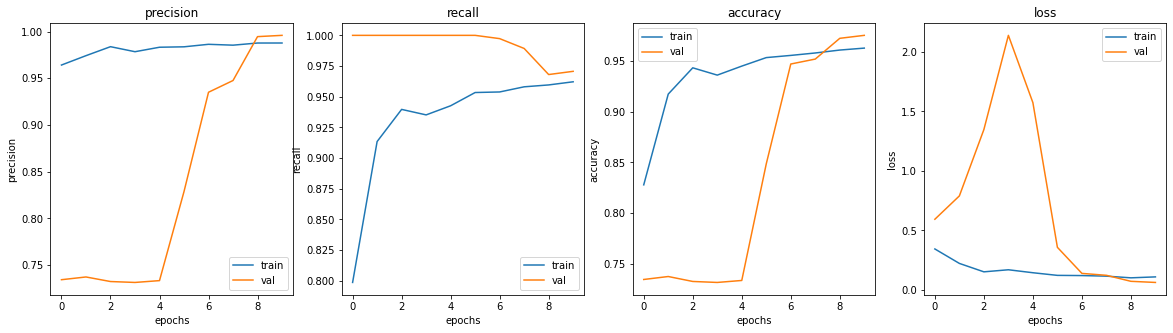

## 실험 2) ResNet18 vs CNN

- CNN
    - Set
        - Epoch : 10
        - Batch :16
        - Aug : True
        - 추가 사항 : 
            - `이미지 흑백 변환`
            - `224 보다 작은 이미지 제거`
    - test
        - Loss: 0.828903079032898,
        - `Accuracy: 0.7708`333134651184,
        - Precision: 0.7334593534469604,
        - Recall: 0.9948717951774597
        
        

- ResNet 18
    - Set
        - Epoch : 10
        - Batch :32
        - Aug : True
        - 추가 사항 : 
            - 이미지 흑백 변환
            - 224 보다 작은 이미지 제거
    - test
        - Loss: 4.934681415557861,
        - Accuracy: 0.625,
        - Precision: 0.625,
        - Recall: 1.0
        


# 최종 결론

1. `ResNet18`은 모든 Accuracy가 0.625로 일정하게 나온다. 
    - `모델 복잡도가 높아`서 현 데이터셋에 대해 적응을 못하고 있다
2. `CNN`이 모델이 ResNet18보다 `성능이 좋다`
    - 모델 복잡도가 낮은 CNN이 성능이 더 좋았다. 
3. 전처리 방식을 2가지를 추가함으로써 성능이 향상했다.
    - 실험 과정에서 아쉬운 점이 'Augmentation'이 True, False로 다른 상태로 실험에 임해서 Augmentation이 영향을 줄 수도 있다. 
    - 본인(나)은 Augmentation 방식 중에서 `좌우반전`만 사용했음으로 성능에 영향을 안미첬을 것으로 판단한다.
    - 추가한 전처리 방식
        1. 이미지 흑백 변환
            - 데이터 중에 흑백으로 있는 이미지와 노란색(?)으로 있는 이미지가 있음을 확인했다. 이에 대해 노란색 이미지를 흑백 3채널로 변환하였다. 
        2. (224,224) 보다 작은 이미지 제거
            - 이미지의 사이즈 분포를 확인해본 결과, 가로,세로 둘 중 하나라도 224보다 작은 이미지가 약 40개 존재했다. 작은 이미지를 큰 사이즈로 리사이즈하게 되면 블러(blur)효과가 나타나 악영향을 미칠것으로 판단하여, 제거를 하였다.
            - 224 사이즈로 정한 이유는 Resnet18 입력으로 들어가는 이미지 사이즈가 224,224 였기 때문이다.
            
4. 아쉬운 점
    1. 이미지 전처리 방식중에 리사이즈하기 전에 Center_Crop, Crop, Padding 등을 적용하여 실험을 못했다. 특히 `Center_Crop`은 실험해보고 싶었다. 사이즈가 작은(224 미만) 이미지들은 주로 폐 이미지만 존재하였고, 사이즈가 큰(1000 초과)하는 이미지들은 주로 폐, 턱, 배(?), 양쪽 팔이 포함되어 있었다. 사이즈가 큰 이미지들을 Center_Crop하여 폐 이미지만 학습하면 성능이 향상할 것 같았다. 
    2. 퀘스트 임무(?) 중에 Resnet18을 써보라는 이유가 있었을 것이다. 출제자는 성능이 향상되서 써보라고 한것 같았지만, 본인(나)은 오히려 test셋에서 성능이 일정하게 나와 문제가 있다고 판단했다. 이에 대해 좀 더 연구(learning rate 등)을 해보면 좋앗을 것 같다.
    3. CNN 에폭을 더 늘려서 학습못한 것이 아쉽다. 10에폭을 학습시키는데 갑자기 커널이 죽는 경우가 많았다. 메모리 문제는 아닌 것이 배치사이즈를 줄여도 터지거나, 동일하더라도 이유없이 터지는 경우가 많았다.